In [2]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import pandas as pd
import shutil

In [3]:
from fastai import *
from fastai.vision import *

#### Dataset

In [4]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
sls.j_kk.sum()

15657016

In [10]:
sls.shape

(222861, 37)

In [7]:
sls['idslsnon_rd'] = sls['idslsnon_rd'].apply(lambda x: str(x).zfill(4))

In [8]:
sls["idsls"] = sls.iddesa_rd.apply(str)+sls.idslsnon_rd.apply(str)         

In [11]:
df =  pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/list_image.csv")

In [12]:
path = 'C:/Users/jwst2/Python/tesis/jpg/general sls sentinel 10m tc/'
onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

In [13]:
dffile = pd.DataFrame(onlyfiles)

In [17]:
dffile.columns = ["filename"]

In [18]:
dffile.filename = dffile.filename.str.replace(".jpg","")

C:\Users\jwst2\AppData\Local\Temp/ipykernel_27924/1409568172.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dffile.filename = dffile.filename.str.replace(".jpg","")


In [56]:
slsall= dffile.set_index("filename").join(sls.set_index("idsls"), how = "left")

In [57]:
slsall.j_kk.sum()

15656914.0

In [58]:
15657016-15656914

102

In [59]:
slsall.to_csv("C:/Users/jwst2/Python/tesis/dataset/data_sls_map.csv")

In [60]:
slsall["full_path"] = path+slsall.index+".jpg"

In [61]:
slsall.shape

(222876, 37)

In [62]:
slsall.dropna(subset = ["j_kk"],inplace=True)

In [64]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock), # finds the images in the path
    splitter=RandomSplitter(valid_pct=0.1,seed=42),
    get_x = lambda r: r['full_path'], get_y = lambda r: r['j_kk']
)

In [65]:
dls = dblock.dataloaders(slsall)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [66]:
slsall["j_kk"].isna().sum()

0

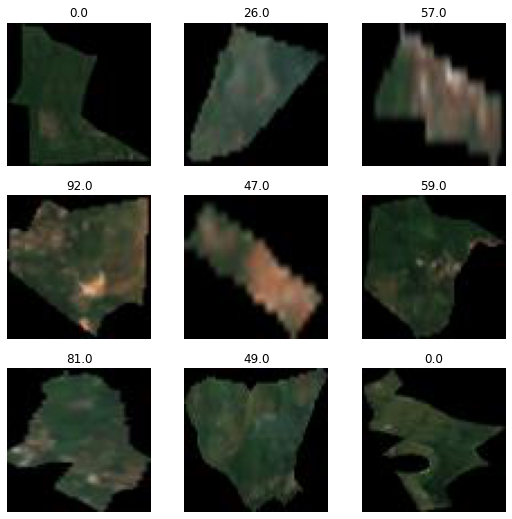

In [67]:
dls.show_batch()

#### Resnet Regression

In [71]:
learn = cnn_learner(dls, resnet50,metrics = [mse, rmse,msle,mae,R2Score(),PearsonCorrCoef(),SpearmanCorrCoef()])
learn.loss = MSELossFlat

In [72]:
learn.unfreeze()

In [73]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,mse,_rmse,msle,mae,r2_score,pearsonr,spearmanr,time
0,2911.562012,4795.615723,4795.615723,69.250389,1.120269,29.721399,0.221484,0.485309,0.562464,10:55
1,5241.776367,1951418.250000,1951418.250000,1396.932007,1.193062,98.111450,-315.791794,0.319591,0.622393,10:47
2,5763.947754,2797415.750000,2797415.750000,1672.547485,nan,111.439713,-453.130105,0.230785,0.641677,10:48


In [74]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mse,_rmse,msle,mae,r2_score,pearsonr,spearmanr,time
0,3120.965820,739766.250000,739766.250000,860.096741,1.192540,65.493721,-119.093073,0.237438,0.638321,10:37
1,3594.482178,274669568.000000,274669568.000000,16573.166016,1.351959,728.640869,-44588.679438,0.162587,0.534642,10:59
2,4650.064453,30082062.000000,30082062.000000,5484.711914,nan,251.778748,-4882.497970,0.135288,0.535650,11:00
3,3945.936523,5257.660645,5257.660645,72.509743,nan,29.824492,0.146475,0.432023,0.593299,10:46
4,5942.624023,502887956348928.000000,502887956348928.000000,22425166.000000,nan,1576950.250000,-81638435204.961777,-0.019197,0.549508,10:45
5,4945.291992,677253260247040.000000,677253260247040.000000,26024090.000000,nan,981690.062500,-109944737615.969345,0.022404,0.585913,10:46
6,3042.074707,437369605980160.000000,437369605980160.000000,20913384.000000,nan,740668.562500,-71002229880.191681,0.102674,0.599087,10:52
7,6172.125488,5860915593347072.000000,5860915593347072.000000,76556632.000000,nan,4234061.000000,-951456618094.068848,0.146453,0.624053,10:50
8,3549.348145,169793042776064.000000,169793042776064.000000,13030469.000000,nan,637538.187500,-27564076997.634094,0.168077,0.628509,10:47
9,5110.046875,71350395863040.000000,71350395863040.000000,8446916.000000,nan,446082.062500,-11582964832.874126,0.161664,0.628753,10:47


In [18]:
interp = Interpretation.from_learner(learn)

In [ ]:
learn.export('C:/Users/jwst2/Python/tesis/models/04012022_resne50_jk_sentinel_10m_reg_1080.pkl')

#### Densenet Regression

In [108]:
learn_ls = cnn_learner(dls, densenet121,metrics = [mae,R2Score()])
learn_ls.loss = MSELossFlat

In [109]:
learn_ls.fine_tune(20)

epoch,train_loss,valid_loss,mae,r2_score,time
0,6391.472656,4266.698730,31.235775,0.353934,09:00


epoch,train_loss,valid_loss,mae,r2_score,time
0,4606.228027,9579.305664,32.290813,-0.450504,10:45
1,5625.727539,5161.827637,30.265503,0.218393,10:50
2,3054.882080,29194.869141,33.904099,-3.420704,10:48
3,3082.864746,99288.273438,35.892708,-14.034290,10:48
4,3394.031982,284005.375000,43.912621,-42.004266,10:51
5,2723.591309,8891076.000000,103.721947,-1345.291854,10:53
6,4460.077148,1352004.750000,42.644291,-203.721426,10:52
7,3084.514893,9198647.000000,86.053909,-1391.864437,10:54
8,3181.310547,924051.687500,39.134022,-138.920561,10:53
9,2107.740967,186253344.000000,253.065231,-28201.701957,10:55


In [ ]:
learn_ls.export('C:/Users/jwst2/Python/tesis/models/04012022_densenet121_jk_sentinel_10m_reg_1018.pkl')

#### Stratified

In [ ]:
xmin = desa.j_kk.min()
xmax = desa.j_kk.max()

In [ ]:
bh = []
bh.append(xmin)
l = 16
for h in range(1,l):
    bh.append(xmin*pow((xmax/xmin),(h/l)))
    
bh.append(xmax)

In [ ]:
bh1 = bh.copy()
bh2 = bh.copy()

bh1.pop(l)
bh2.pop(0)

In [ ]:
bins = pd.IntervalIndex.from_arrays(bh1,bh2)
cutter = pd.cut(desa.j_kk, bins)

In [ ]:
pd.DataFrame(cutter).value_counts().plot(kind='bar')

In [ ]:
desa["bin_jk"] = cutter
desa["jk"] = 0

In [ ]:
j = 1
for i in bins:
    desa.jk[desa.bin_jk == i]= j
    j= j+1

#### Preprocessing

In [ ]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/')
if os.path.isdir('jabar_jk/1') is False:
    for i in range(1,17):
        os.makedirs('jabar_jk/'+str(i))
    

In [ ]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 1 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/1/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 2 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/2/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 3 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/3/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 4 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/4/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 5 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/5/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 6 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/6/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 7 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/7/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 8 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/8/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 9 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/9/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 10 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/10/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 11 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/11/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 12 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/12/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 13 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/13/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 14 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/14/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 15 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/15/"+name)
        elif(desa.jk[desa.index == int(name.replace(".jpg",""))].iloc[0] == 16 ):
            shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar_jk/16/"+name)

#### Models

In [ ]:
path = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/jabar_jk")

In [ ]:
Path.BASE_PATH = path
path.ls()

In [ ]:
fname = (path/"1").ls()[0]
fname

In [ ]:
img = Image.open(fname)
img

In [ ]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

In [ ]:
dls = blocks.dataloaders(path)

In [ ]:
dls.show_batch(nrows=1, ncols=5)

In [ ]:
blocks = blocks.new(batch_tfms=aug_transforms(mult=2.0))
dls = blocks.dataloaders(path)
dls.train.show_batch(nrows=3, unique=True)

#### Densenet

In [ ]:
avg = 'macro'
metrics=[accuracy, Precision(average=avg), Recall(average=avg), F1Score(average=avg)]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

In [ ]:
learn.fine_tune(10)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

In [341]:
learn.export('C:/Users/jwst2/Python/tesis/models/02012022_densenet121_jk16_sentinel_def_270.pkl')

#### Densenet Xgboost

In [272]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-14:-4])

In [274]:
idx_valid = []
for i in dls.valid.items:
    idx_valid.append(str(i)[-14:-4])

In [ ]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [275]:
preds,_ = learn.get_preds(ds_idx  = 1)
result_test = preds.numpy()
new_test = pd.DataFrame(result_test)

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [277]:
new_test["iddesa"] = idx_valid 

In [279]:
new_train["iddesa"] = idx_train 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [293]:
df_pred =  new_train.append(new_test)
df_pred.iddesa = df_pred.iddesa.apply(int)

In [296]:
df = df_pred.set_index('iddesa').join(desa)

In [304]:
df = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,"j_kk"]]
df.columns = ["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8","prob9","prob10","prob11","prob12","prob13","prob14","prob15","prob16","jk"]

In [306]:
df.to_csv("C:/Users/jwst2/Python/tesis/dataset/jkk_densenet_desa_sentinel.csv")

In [320]:
df = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/jkk_densenet_desa_sentinel.csv")
X = df.drop(["jk","iddesa"],axis = 1)
y = df.jk
X= X*100

In [326]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
xgb_model = xgb.XGBRegressor()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = { #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05,0.025,0.01], #so called `eta` value
              'max_depth': [3,6,10,15],
              'min_child_weight': [3,5,11],
              'subsample': [0.8,0.9,1],
              'colsample_bytree': [0.7,0.9],
              'n_estimators': [10,50,100,250,500], #number of trees, change it to 1000 for better result
              'use_label_encoder': [False], 
              'objective':['reg:squarederror']
}


clf = GridSearchCV(xgb_model, parameters, cv=5,scoring='neg_mean_squared_error',n_jobs= -1)

clf.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9],
                         '

In [328]:
clf.best_score_

-5220527.6323994305

In [329]:
clf.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.025,
 'max_depth': 3,
 'min_child_weight': 11,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.8,
 'use_label_encoder': False}

In [343]:
clf.best_estimator_.save_model('C:/Users/jwst2/Python/tesis/models/02012022_xgb_densenet121_jk16_sentinel_def_5220527.json')

#### Resnet

In [29]:
learn_rs = cnn_learner(dls, resnet50, metrics=root_mean_squared_error) 

NameError: name 'root_mean_squared_error' is not defined

In [ ]:
learn_rs.fine_tune(20)

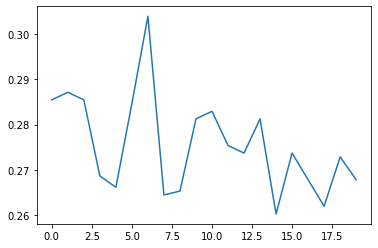

In [336]:
plt.plot(L(learn_rs.recorder.values).itemgot(2));

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


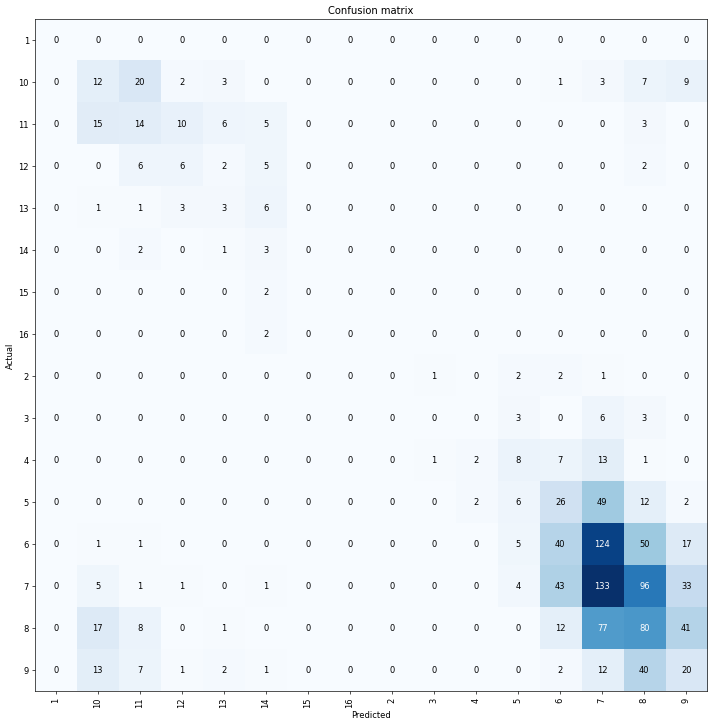

In [344]:
interp = ClassificationInterpretation.from_learner(learn_rs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [345]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/02012020_resnet50_jk16_sentinel_def_267.pkl')

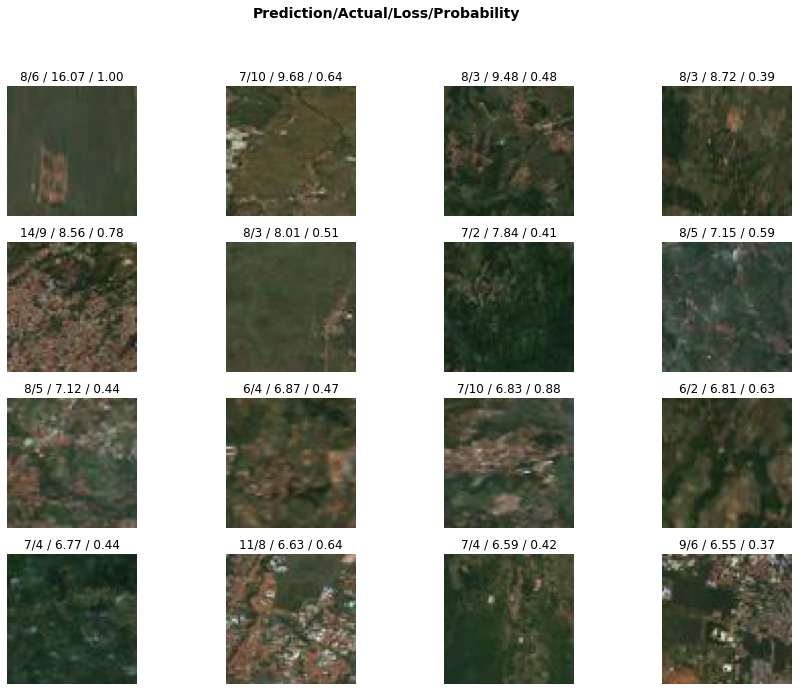

In [346]:
interp.plot_top_losses(16, figsize=(15,11))

#### Resnet XGBoost

In [357]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-14:-4])
    
idx_valid = []
for i in dls.valid.items:
    idx_valid.append(str(i)[-14:-4])

preds,_ = learn_rs.get_preds(ds_idx  = 1)
result_test = preds.numpy()
new_test = pd.DataFrame(result_test)

preds,_ = learn_rs.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)
new_test["iddesa"] = idx_valid 
new_train["iddesa"] = idx_train 
df_pred =  new_train.append(new_test)
df_pred.iddesa = df_pred.iddesa.apply(int)
df = df_pred.set_index('iddesa').join(desa)


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [361]:
df[["j_kk","klas_ur","jk"]].to_csv("C:/Users/jwst2/Python/tesis/dataset/list_image.csv")

In [351]:
df = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,"j_kk"]]
df.columns = ["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8","prob9","prob10","prob11","prob12","prob13","prob14","prob15","prob16","jk"]
df.to_csv("C:/Users/jwst2/Python/tesis/dataset/jkk_resnet_desa_sentinel.csv")


In [353]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5956 entries, 0 to 1190
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5956 non-null   float32
 1   1       5956 non-null   float32
 2   2       5956 non-null   float32
 3   3       5956 non-null   float32
 4   4       5956 non-null   float32
 5   5       5956 non-null   float32
 6   6       5956 non-null   float32
 7   7       5956 non-null   float32
 8   8       5956 non-null   float32
 9   9       5956 non-null   float32
 10  10      5956 non-null   float32
 11  11      5956 non-null   float32
 12  12      5956 non-null   float32
 13  13      5956 non-null   float32
 14  14      5956 non-null   float32
 15  15      5956 non-null   float32
 16  iddesa  5956 non-null   int64  
dtypes: float32(16), int64(1)
memory usage: 465.3 KB


In [352]:
to_ind=df_pred["iddesa",""]

,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8,prob9,prob10,prob11,prob12,prob13,prob14,prob15,prob16,jk
iddesa,,,,,,,,,,,,,,,,,
3208130011,0.000088,0.036315,0.004425,0.001136,0.000446,0.000031,0.000108,1.573378e-05,0.000324,0.000572,0.007222,0.042556,0.199190,0.447399,0.150788,0.109384,2777
3202021001,0.000039,0.001073,0.000106,0.000088,0.000036,0.000026,0.000006,3.724456e-06,0.000086,0.002098,0.006272,0.059206,0.523035,0.363997,0.039354,0.004575,1658
3205161006,0.000077,0.027191,0.015208,0.001502,0.001081,0.000406,0.000235,9.951285e-05,0.000529,0.000490,0.002160,0.011271,0.012210,0.183621,0.570604,0.173315,1839
3278030003,0.000084,0.007444,0.001521,0.000422,0.000302,0.000037,0.000079,3.268775e-05,0.000346,0.001480,0.004928,0.034279,0.352888,0.373376,0.166867,0.055914,1639
3208080016,0.000309,0.000124,0.000025,0.000013,0.000008,0.000013,0.000005,1.177136e-05,0.000294,0.001479,0.012257,0.975283,0.005034,0.001927,0.003105,0.000112,824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206040003,0.000084,0.001314,0.000483,0.000239,0.000119,0.000131,0.000050,1.174106e-05,0.001689,0.003608,0.019873,0.111940,0.335028,0.388918,0.128311,0.008203,1271
3217010001,0.000004,0.000440,0.000099,0.000072,0.000031,0.000013,0.000005,1.003065e-06,0.000036,0.000301,0.000482,0.024273,0.427964,0.477619,0.057998,0.010663,1929
3206211005,0.000008,0.002321,0.001839,0.001154,0.000315,0.000107,0.000082,9.006818e-06,0.000333,0.000189,0.004802,0.023306,0.147411,0.517873,0.243008,0.057243,1045


In [362]:
df = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/jkk_resnet_desa_sentinel.csv")
X = df.drop(["jk","iddesa"],axis = 1)
y = df.jk
X= X*100

In [363]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
xgb_model = xgb.XGBRegressor()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = { #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05,0.025,0.01], #so called `eta` value
              'max_depth': [3,6,10,15],
              'min_child_weight': [3,5,11],
              'subsample': [0.8,0.9,1],
              'colsample_bytree': [0.7,0.9],
              'n_estimators': [10,50,100,250,500], #number of trees, change it to 1000 for better result
              'use_label_encoder': [False], 
              'objective':['reg:squarederror']
}


clf = GridSearchCV(xgb_model, parameters, cv=5,scoring='neg_mean_squared_error',n_jobs= -1)

clf.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9],
                         '

In [365]:
clf.best_score_

-3834288.2016783925

In [ ]:
clf.best_params_

In [366]:
clf.best_estimator_.save_model('C:/Users/jwst2/Python/tesis/models/02012022_xgb_resnet50_jk16_sentinel_def_3834288.json')